# 09. PyTorch Model Deployment

What is model deployment?

Machine learning model deployment is the act of making your machine learning model(s) available to someone or something else.


## 0. Get setup

In [3]:
import torch 
import torchvision
import matplotlib.pyplot as palt 

from torch import nn 
from torchvision import transforms

from torchinfo import summary

from going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Getting Data

The dataset we're going to use for deploying a FoodVision Mini model is....

Pizza, Steak, Sushi dataset (pizza, steak, sushi classes from Food101)

### 1.1 Setup the data path

In [6]:
import pathlib
data_dir = pathlib.Path('data')
data_dir

WindowsPath('data')

### 1.2 Download data

Get the Food101 dataset from PyTorch

In [8]:
# Get training data
from torchvision import datasets
train_data = datasets.Food101(root=data_dir,
                             split='train',
                             download=True)

# Get testing data 
test_data = datasets.Food101(root=data_dir,
                            split='test',
                            download=True)

100%|█████████████████████████████████████████████████████████████████████████████| 5.00G/5.00G [13:42<00:00, 6.07MB/s]


Extracting data\food-101.tar.gz to data


### 1.3 Find subset of appropriate classes

Want: Steak, Pizza, Sushi.

Current path setup: ../data/food-101/images/CLASS_NAME/IMAGES.jpg

Going to get a list of the different target images classes (pizza, steak, sushi) filenames and then copy the images to seperate folders.

In [11]:
import random 

# Setup data paths 
data_path = data_dir / 'food-101'/ 'images'
target_classes = ['pizza', 'steak', 'sushi']

amount_to_get = 0.99

# Create function to seperate a random amount of data 
def get_subset(image_path=data_path,
              data_splits=['train', 'test'],
              target_classes=['pizza', 'steak', 'sushi'],
               amount=0.1,
               seed=42
              ):
    random.seed(seed)
    label_splits = {}

    # Get labels 
    for data_split in data_splits:
        print(f'[INFO] Creating image split for: {data_split}...')
        label_path = data_dir / 'food-101' / 'meta'/ f'{data_split}.txt'
        with open(label_path, 'r') as f:
            labels = [line.strip("\n") for line in f.readlines() if line.split("/")[0] in target_classes] 
        
        # Get random subset of target classes image ID's
        number_to_sample = round(amount * len(labels))
        print(f"[INFO] Getting random subset of {number_to_sample} images for {data_split}...")
        sampled_images = random.sample(labels, k=number_to_sample)
        
        # Apply full paths
        image_paths = [pathlib.Path(str(image_path / sample_image) + ".jpg") for sample_image in sampled_images]
        label_splits[data_split] = image_paths
    return label_splits
        
label_splits = get_subset(amount=amount_to_get)
label_splits["train"][:10]
            
    

[INFO] Creating image split for: train...
[INFO] Getting random subset of 2228 images for train...
[INFO] Creating image split for: test...
[INFO] Getting random subset of 742 images for test...


[WindowsPath('data/food-101/images/pizza/3269634.jpg'),
 WindowsPath('data/food-101/images/pizza/1524655.jpg'),
 WindowsPath('data/food-101/images/steak/2825100.jpg'),
 WindowsPath('data/food-101/images/steak/225990.jpg'),
 WindowsPath('data/food-101/images/steak/1839481.jpg'),
 WindowsPath('data/food-101/images/pizza/38349.jpg'),
 WindowsPath('data/food-101/images/pizza/3018077.jpg'),
 WindowsPath('data/food-101/images/sushi/93139.jpg'),
 WindowsPath('data/food-101/images/pizza/2702825.jpg'),
 WindowsPath('data/food-101/images/sushi/200025.jpg')]

In [12]:
# Create target directory path
target_dir_name = f"data/pizza_steak_sushi_{str(int(amount_to_get*100))}_percent"
print(f"Creating directory: '{target_dir_name}'")

# Setup the directories
target_dir = pathlib.Path(target_dir_name)

# Make the directories
target_dir.mkdir(parents=True, exist_ok=True)

Creating directory: 'data/pizza_steak_sushi_99_percent'


In [16]:
import shutil

for image_split in label_splits.keys():
    for image_path in label_splits[str(image_split)]:
        dest_dir = target_dir / image_split / image_path.parent.stem / image_path.name
        if not dest_dir.parent.is_dir():
            dest_dir.parent.mkdir(parents=True, exist_ok=True)
        #print(f"[INFO] Copying {image_path} to {dest_dir}...")
        shutil.copy2(image_path, dest_dir)

In [22]:
# Setup training and test paths 
train_dir = target_dir / 'train'
test_dir = target_dir / 'test'

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi_99_percent/train'),
 WindowsPath('data/pizza_steak_sushi_99_percent/test'))

## 2. FoodVision Mini model deployment experiment outline

### 3 Questions:
1. What is my most ideal machine learning model deployment scenario?
2. Where is my model going to go?
3. How is my model going to function?

**FoodVision Mini ideal use case:** A model performs well and fast.

1. Performs well: 95%+ accuracy
2.  Fast: as close to real-time (or faster) as possible (30FPS+ or 30ms latency)
    * Latency = time for prediction to take place
  
To try and achieve these goals, we're going to build two model experiments:

1. EffNetB2 feature extractor
2. ViT feature extractor


## 3. Creating an EffNetB2 feature extractor

Feature extractor = a term for a transfer learning model that has it's base layers frozen and output layers (or head layers) customized to a certain problem.

In [25]:
# 1. setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model instances
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# 4. Freeze the base layers in the model (this will stop all layers from training)
for param in effnetb2.features.parameters():
    param.requires_grad = False


In [29]:
from torchinfo import summary

# Print EffNetB2 model summary 
# summary(effnetb2, 
#        input_size=[1, 3, 224, 224],
#        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
#        col_width=20,
#        row_settings=['var_names'])

In [27]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [28]:
# Set seeds for reproducibility
set_seeds()
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True)
)

In [30]:
# Print EffNetB2 model summary 
summary(effnetb2, 
       input_size=[1, 3, 224, 224],
       col_names=['input_size', 'output_size', 'num_params', 'trainable'],
       col_width=20,
       row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.1 Creaing a function to make an EffNetB2 feature extractor

In [31]:
def create_effnetb2_model(num_classes:int=3,
                         seed:int=42):
    # 1, 2, 3 Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in the base model
    for param in model.parameters():
        param.requires_grad = False 

    # 5. Change classifier head with random seed for reporducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes, bias=True)
    )

    return model, transforms

In [42]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3)

In [43]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [44]:
# Print EffNetB2 model summary 
summary(effnetb2, 
       input_size=[1, 3, 288, 288],
       col_names=['input_size', 'output_size', 'num_params', 'trainable'],
       col_width=20,
       row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 288, 288]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 288, 288]     [1, 1408, 9, 9]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 288, 288]     [1, 32, 144, 144]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 288, 288]     [1, 32, 144, 144]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 144, 144]    [1, 32, 144, 144]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 144, 144]    [1, 32, 144, 144]    --                   --
│    └─Sequential (1)                                        [1, 32, 144, 144]    [1, 1

### 3.2 Creating DataLoaders for EffNetB2


In [45]:
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=effnetb2_transforms,
    batch_size=32
)

In [46]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(70, 24, ['pizza', 'steak', 'sushi'])

### 3.3 Training EffNetB2 feature extractor

In [47]:
from going_modular import engine
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer 
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=0.001)

# Train
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                               train_dataloader=train_dataloader_effnetb2,
                               test_dataloader=test_dataloader_effnetb2,
                               loss_fn=loss_fn,
                               optimizer=optimizer,
                               epochs=20,
                               device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6720 | train_acc: 0.7714 | test_loss: 0.3504 | test_acc: 0.9466
Epoch: 2 | train_loss: 0.3923 | train_acc: 0.8873 | test_loss: 0.2426 | test_acc: 0.9518
Epoch: 3 | train_loss: 0.3176 | train_acc: 0.9022 | test_loss: 0.2141 | test_acc: 0.9570
Epoch: 4 | train_loss: 0.2836 | train_acc: 0.9053 | test_loss: 0.1886 | test_acc: 0.9544
Epoch: 5 | train_loss: 0.2618 | train_acc: 0.9105 | test_loss: 0.1685 | test_acc: 0.9557
Epoch: 6 | train_loss: 0.2498 | train_acc: 0.9113 | test_loss: 0.1601 | test_acc: 0.9570
Epoch: 7 | train_loss: 0.2339 | train_acc: 0.9193 | test_loss: 0.1499 | test_acc: 0.9531
Epoch: 8 | train_loss: 0.2417 | train_acc: 0.9142 | test_loss: 0.1567 | test_acc: 0.9531
Epoch: 9 | train_loss: 0.2267 | train_acc: 0.9215 | test_loss: 0.1444 | test_acc: 0.9544
Epoch: 10 | train_loss: 0.2056 | train_acc: 0.9325 | test_loss: 0.1396 | test_acc: 0.9531
Epoch: 11 | train_loss: 0.1990 | train_acc: 0.9288 | test_loss: 0.1388 | test_acc: 0.9544
Epoch: 12 | train_l

### 3.4 Inspecting EffNetB2 Loss Curves

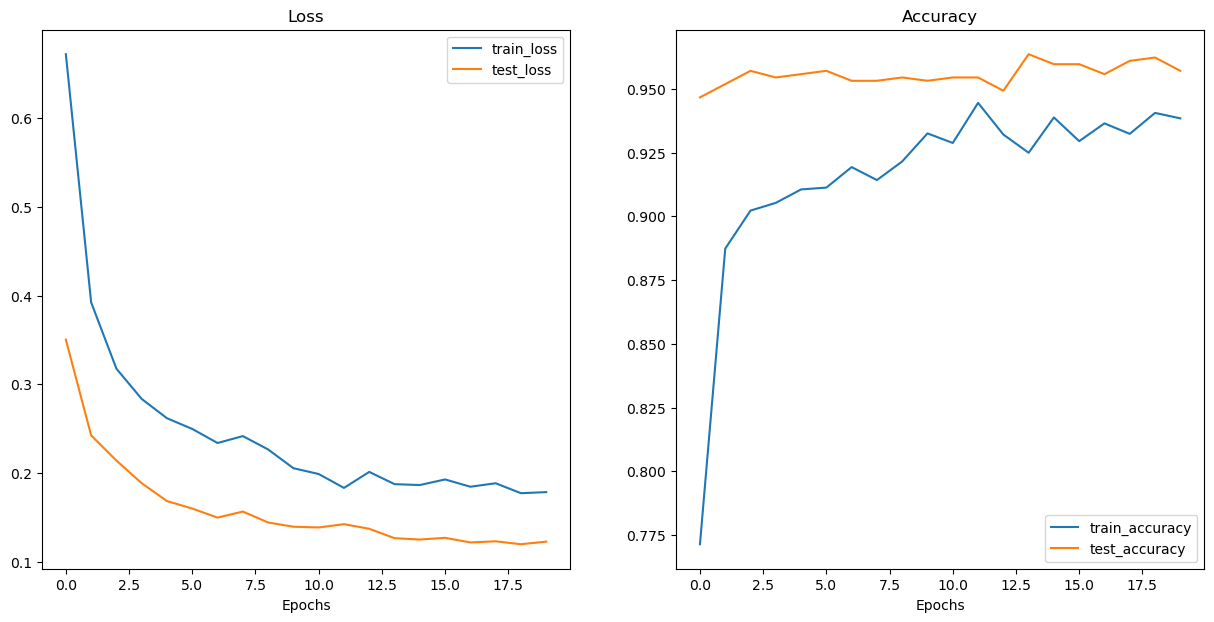

In [48]:
plot_loss_curves(effnetb2_results)

### 3.5 Saving EffNetB2 feature extractor

In [49]:
from going_modular import utils

In [51]:
utils.save_model(effnetb2,
                target_dir='models',
                model_name='pretrained_effnetb2_feature_extractor_pizza_steak_sushi.pth')

[INFO] Saving model to: models\pretrained_effnetb2_feature_extractor_pizza_steak_sushi.pth


### 3.6 Inspecting the size of our EffNetB2 feature extractor 

Why would it be important to consider the size of a saved model? 

If we're deploying our model to be used on a mobile/app website, there may be limited compute resources.

So if our model file is too large, we may not be able to store/run it on our target device.

In [58]:
from pathlib import Path

# Get the model size in bytes and convert to megabytes
pretrained_effnetb2_model_size = Path('models\pretrained_effnetb2_feature_extractor_pizza_steak_sushi.pth').stat().st_size / (1024 * 1024)
print(f'Pretrained effnetb2 feature extractor model size: {pretrained_effnetb2_model_size:.2f} MB')

Pretrained effnetb2 feature extractor model size: 29.85 MB


### 3.7 Collecting EffNetB2 Feature extractor stats

In [61]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [62]:
# Create a dictionary with EffNetB2 statistics 
effnetb2_stats = {'test_loss': effnetb2_results['test_loss'][-1],
                 'test_acc': effnetb2_results['test_acc'][-1],
                 'number_of_parameters': effnetb2_total_params,
                 'model_size (MB)': pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.12282744934782386,
 'test_acc': 0.95703125,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8526554107666}

## 4. Creating a Vit feature extractor

We're up to our second modelling experiment, repeating the steps for EffNetB2 but this time with a ViT feature extractor

### 4.1 Create DataLoaders for ViT

In [65]:
# Check out the ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [67]:
def create_vit_models(num_classes:int=3,
                     seed:int=42):
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad=False

    # Change classifier head 
    torch.manual_seed(seed)
    model.heads = nn.Sequential(
        nn.Linear(in_features=768, out_features=3, bias=True)
    )
    return model, transforms

In [68]:
vit, vit_transforms = create_vit_models()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [70]:
summary(vit, 
       input_size=[1, 3, 224, 224],
       col_names=['input_size', 'output_size', 'num_params', 'trainable'],
       col_width=20,
       row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 4.1 Create DataLoaders for ViT feature extractor

In [71]:

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=vit_transforms,
    batch_size=32
)

len(train_dataloader_vit), len(test_dataloader_vit), class_names

(70, 24, ['pizza', 'steak', 'sushi'])

### 4.2 Training ViT Features Extractor

In [73]:
# Loss fn 
loss_fn = nn.CrossEntropyLoss()

# Optimizer 
optimizer = torch.optim.Adam(params=vit.parameters(), lr=0.001)

# Train
set_seeds()
vit_results = engine.train(model=vit,
                               train_dataloader=train_dataloader_vit,
                               test_dataloader=test_dataloader_vit,
                               loss_fn=loss_fn,
                               optimizer=optimizer,
                               epochs=20,
                               device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2833 | train_acc: 0.9071 | test_loss: 0.0970 | test_acc: 0.9727
Epoch: 2 | train_loss: 0.1262 | train_acc: 0.9573 | test_loss: 0.0763 | test_acc: 0.9766
Epoch: 3 | train_loss: 0.0982 | train_acc: 0.9692 | test_loss: 0.0685 | test_acc: 0.9766
Epoch: 4 | train_loss: 0.0811 | train_acc: 0.9772 | test_loss: 0.0642 | test_acc: 0.9766
Epoch: 5 | train_loss: 0.0706 | train_acc: 0.9796 | test_loss: 0.0625 | test_acc: 0.9779
Epoch: 6 | train_loss: 0.0593 | train_acc: 0.9857 | test_loss: 0.0603 | test_acc: 0.9818
Epoch: 7 | train_loss: 0.0511 | train_acc: 0.9906 | test_loss: 0.0595 | test_acc: 0.9818
Epoch: 8 | train_loss: 0.0442 | train_acc: 0.9915 | test_loss: 0.0631 | test_acc: 0.9779
Epoch: 9 | train_loss: 0.0401 | train_acc: 0.9929 | test_loss: 0.0580 | test_acc: 0.9831
Epoch: 10 | train_loss: 0.0358 | train_acc: 0.9951 | test_loss: 0.0575 | test_acc: 0.9818
Epoch: 11 | train_loss: 0.0322 | train_acc: 0.9946 | test_loss: 0.0577 | test_acc: 0.9831
Epoch: 12 | train_l

### 4.3 Interpreting the Loss Curves for VIT feature extractor

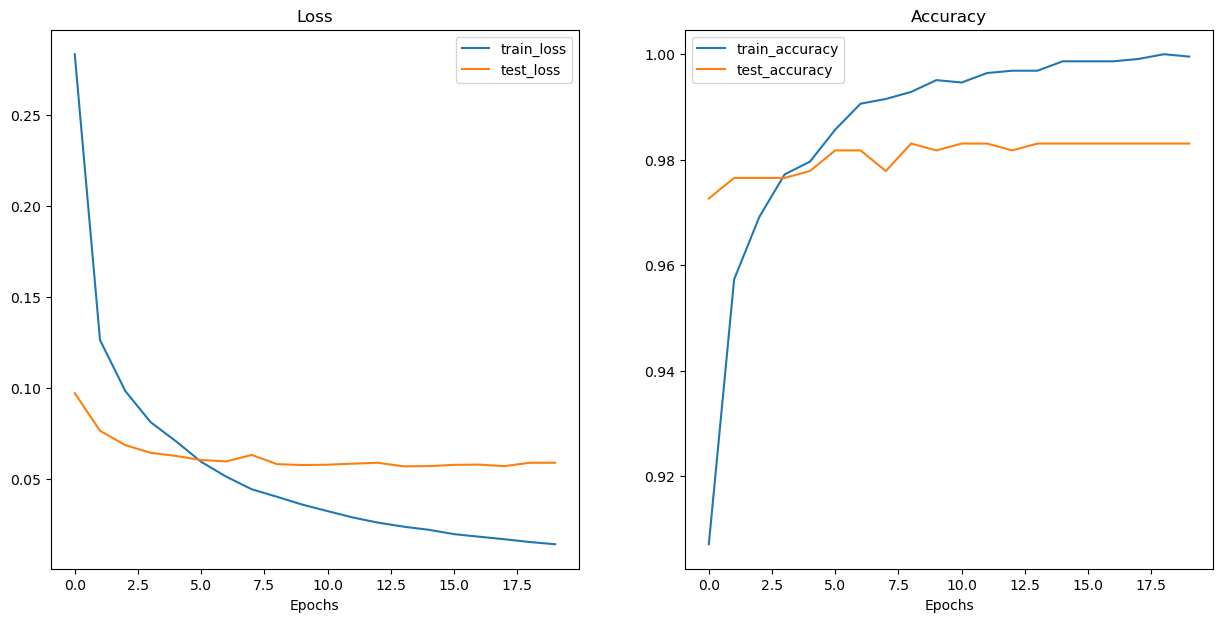

In [74]:
plot_loss_curves(vit_results)

Highly Overfitting but that's okay for now.

### 4.4 Saving ViT feature extractor

In [75]:
utils.save_model(vit,
                target_dir='models',
                model_name='pretrained_vit_feature_extractor_pizza_steak_sushi.pth')

[INFO] Saving model to: models\pretrained_vit_feature_extractor_pizza_steak_sushi.pth


### 4.5 Checking the size of ViT feature extractor

In [83]:
from pathlib import Path

# Get the model size in bytes and convert to megabytes
pretrained_vit_model_size = Path('models\pretrained_vit_feature_extractor_pizza_steak_sushi.pth').stat().st_size / (1024 * 1024)
print(f'Pretrained effnetb2 feature extractor model size: {pretrained_effnetb2_model_size:.2f} MB')

Pretrained effnetb2 feature extractor model size: 327.37 MB


### 4.6 Collecting ViT feature extractor stats

In [77]:
# Count number of parameters in EffNetB2
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [84]:
# Create a dictionary with EffNetB2 statistics 
vit_stats = {'test_loss': vit_results['test_loss'][-1],
                 'test_acc': vit_results['test_acc'][-1],
                 'number_of_parameters': vit_total_params,
                 'model_size (MB)': pretrained_vit_model_size}
vit_stats

{'test_loss': 0.058747010713886993,
 'test_acc': 0.9830729166666666,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.36876487731934}

## 5. Making predictions with our trained models and timing

Our goal:
1. Performs well (95%+ test accuracy)
2. Fast (30+FPS)

To test criteria two:
1. Loop through test images
2. Time how long each model takes to make a prediction on the image.

Let's work towards making a function called `pred_and_store()` to do so.

First we'll need a list of test image paths

In [88]:
# Get all test data paths
test_data_paths = list(test_dir.glob('*/*.jpg'))
test_data_paths[:4]

[WindowsPath('data/pizza_steak_sushi_99_percent/test/pizza/1001116.jpg'),
 WindowsPath('data/pizza_steak_sushi_99_percent/test/pizza/1032754.jpg'),
 WindowsPath('data/pizza_steak_sushi_99_percent/test/pizza/103708.jpg'),
 WindowsPath('data/pizza_steak_sushi_99_percent/test/pizza/1060407.jpg')]

### 5.1 Creating a function to make prediction across the test dataset.

Steps to create `pred_and_store()`:
1. Create a function that takes a list of paths and a trained PyTorch model and a series of transforms and a list of target class names and a target device.
2. Create an empty list (can return a full list of all predictions later).
3. Loop through the target input paths (the rest of the steps will take place inside the loop).
4. Create an empty dictionary for each sample (prediction statistics will go in here.)
5. Get the sample path and ground truth class from the filepath.
6. Start the prediction timer.
7. Open the image using `PIL.Image.open(path)`'
8. Transform the image to be usable with a given model.
9. Prepare the model for inference by sending it to the target device and turning on `eval()` mode.
10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and perform forward pass + calculate pred prob + pred class
11. Add the pred prob + pred class to empty dictionary from step 4.
12. End the prediction tiemr started in step 6 and add the time to the prediction dictionary.
13. See if the predicted class matches the ground truth class.
14. Append the updated prediction dictionary to the empty list of predictions we created in step 2.
15. Return the list of prediction dictionary.

In [90]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer 
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path], 
                   model: torch.nn.Module,
                   transform: torchvision.transforms, 
                   class_names: List[str], 
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    
    # 2. Create an empty list to store prediction dictionaries
    pred_list = []
    
    # 3. Loop through target paths
    for path in tqdm(paths):
        
        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name
        
        # 6. Start the prediction timer
        start_time = timer()
        
        # 7. Open image path
        img = Image.open(path)
        
        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device) 
        
        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()
        
        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample 
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on) 
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class
            
            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)
    
    # 15. Return list of prediction dictionaries
    return pred_list

### 5.2 Making and timing predictions with EffNetB2

In [91]:
# Make predictions test dataset with EffNetB2
effnet_b2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device='cpu') 

  0%|          | 0/742 [00:00<?, ?it/s]

In [92]:
effnet_b2_test_pred_dicts[:2]

[{'image_path': WindowsPath('data/pizza_steak_sushi_99_percent/test/pizza/1001116.jpg'),
  'class_name': 'pizza',
  'pred_prob': 1.0,
  'pred_class': 'pizza',
  'time_for_pred': 2.284,
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi_99_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9084,
  'pred_class': 'pizza',
  'time_for_pred': 0.0749,
  'correct': True}]

In [93]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd 
effnetb2_test_pred_df = pd.DataFrame(effnet_b2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi_99_percent\test\pizza\1...,pizza,1.0000,pizza,2.2840,True
1,data\pizza_steak_sushi_99_percent\test\pizza\1...,pizza,0.9084,pizza,0.0749,True
2,data\pizza_steak_sushi_99_percent\test\pizza\1...,pizza,0.9699,pizza,0.0695,True
3,data\pizza_steak_sushi_99_percent\test\pizza\1...,pizza,0.9797,pizza,0.0729,True
4,data\pizza_steak_sushi_99_percent\test\pizza\1...,pizza,0.9888,pizza,0.0688,True


In [94]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

correct
True     709
False     33
Name: count, dtype: int64

In [95]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f'EffnetB2 Average time per prediction: {effnetb2_average_time_per_pred}')

EffnetB2 Average time per prediction: 0.0806


> **Note:** Prediction times will vary (much like training times) depending on the hardware you're using.. so generally the faster your compute (eg. CPU or GPU), the faster the prediction will happen. 

In [103]:
# Add average time per prediction to effnetb2 stats
effnetb2_stats['time_per_pred_cpu'] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.12282744934782386,
 'test_acc': 0.95703125,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8526554107666,
 'time_per_pred_cpu': np.float64(0.0806)}

### 5.3 Making and timing predictions with ViT

In [96]:
# Make list of prediction dictionaries with ViT feature extractor model on test images.
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                    model=vit,
                                    transform=vit_transforms,
                                    class_names=class_names,
                                    device='cpu') # hardcode device to CPU because not sure if GPU available 

  0%|          | 0/742 [00:00<?, ?it/s]

In [97]:
# Check the first couple of ViT predictions
vit_test_pred_dicts[:2]

[{'image_path': WindowsPath('data/pizza_steak_sushi_99_percent/test/pizza/1001116.jpg'),
  'class_name': 'pizza',
  'pred_prob': 1.0,
  'pred_class': 'pizza',
  'time_for_pred': 0.5111,
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi_99_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'pred_prob': 1.0,
  'pred_class': 'pizza',
  'time_for_pred': 0.3046,
  'correct': True}]

In [98]:
# Turn vit_test_pred_dicts 
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi_99_percent\test\pizza\1...,pizza,1.0,pizza,0.5111,True
1,data\pizza_steak_sushi_99_percent\test\pizza\1...,pizza,1.0,pizza,0.3046,True
2,data\pizza_steak_sushi_99_percent\test\pizza\1...,pizza,1.0,pizza,0.2397,True
3,data\pizza_steak_sushi_99_percent\test\pizza\1...,pizza,1.0,pizza,0.2220,True
4,data\pizza_steak_sushi_99_percent\test\pizza\1...,pizza,1.0,pizza,0.2082,True


In [99]:
# see how many correct
vit_test_pred_df.correct.value_counts()

correct
True     729
False     13
Name: count, dtype: int64

In [100]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f'ViT average time per prediction: {vit_average_time_per_pred}')

ViT average time per prediction: 0.2321


In [101]:
# Add average time per prediction to ViT stats
vit_stats['time_per_pred_cpu'] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.058747010713886993,
 'test_acc': 0.9830729166666666,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.36876487731934,
 'time_per_pred_cpu': np.float64(0.2321)}

## 6. Comparing model results, prediction times and size

In [105]:
# Turn stat dictionaries into DataFrames
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df['model'] = ['EffNetB2', 'ViT']

# Convert accuracy to percentages
df['test_acc'] = round(df['test_acc'] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.122827,95.70,7705221,29.852655,0.0806,EffNetB2
1,0.058747,98.31,85800963,327.368765,0.2321,ViT


Which model is better? 
* `test_loss` (lower is better) - ViT
* `test_acc` (higher is better) - ViT
* `number_of_parameters` (generally lower is better) - EffNetB2 if a model has more params, it generally takes longer to compute
    * *sometimes models with higher parameters can still perform fast*
 
* `model_size (MB)`- EffNetB2 (for our use case of deploying model on the mobile generally smaller is better.)
* `time_per_pred_cpu` - (lower is better, will be highly dependent on the hardware you're running on) - EffNetB2

Both models fail to achieve our goal of 30+ FPS.... however we could always just try and use EffNetB2 and see how it goes.

In [108]:
# Compare ViT to EffNetB2 across different charactersitcs
pd.DataFrame(df.set_index('model').loc['ViT'] / df.set_index('model').loc['EffNetB2'],columns=['ViT to EffNetB2 ratios']).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.478289,1.027273,11.135432,10.966152,2.879653


### 6.1 Visualizing the speed vs. performance tradeoff

So we've compared our EffNetB2 and ViT Feature extractor models, not let's visualize the comparison with a speed vs. performance plot.

We can do so with matplotlib:
1. Create a scatter plot from the comparison dataFrame to compare EffNetB2 and ViT across test accuracy and prediction time.
2. Add titles and labels to make our plot look nice.
3. Annotate the samples on the scatter plot so we know what's going on.
4. Create a legend based on the model sizes (`model_size (MB)`)

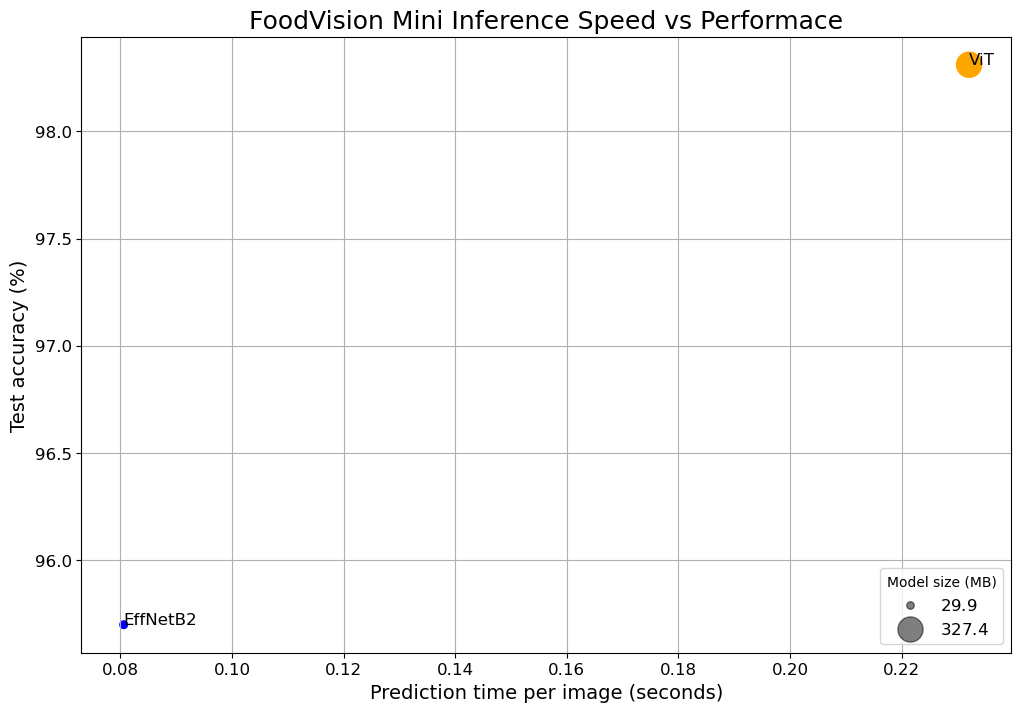

In [121]:
# 1. Create a plot from model comparison DataFrame
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                    x='time_per_pred_cpu',
                    y='test_acc',
                    c=['blue', 'orange'],
                    s='model_size (MB)')

# 2. Add titles and labels
ax.set_title('FoodVision Mini Inference Speed vs Performace', fontsize=18)
ax.set_xlabel('Prediction time per image (seconds)', fontsize=14)
ax.set_ylabel('Test accuracy (%)', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate the samples on the scatter plto so we know what's going on.
for index, row in df.iterrows():
    ax.annotate(text=row['model'],
               xy=(row['time_per_pred_cpu'], row['test_acc']),
               size=12)

# 4. Create a legend based on the model sizes
handles, labels = scatter.legend_elements(prop='sizes', alpha=0.5)
model_size_legend = ax.legend(handles, 
                             labels,
                             loc='lower right',
                             title='Model size (MB)',
fontsize=12)

# Save the figure
# plt.savefig('images/09-foodvision-mini-inference-speed-vs-performance.png')

## 7. Bringing FoodVision Mini to life by creating a Gradio demo

we've choosen to deploy EffNetB2 as it fulfils our criteria the best.

What is Gradio?

> Gradio is the fastest way to demo your machine learning model with a friendly web interface so that anyone can use it, anywhere!


In [125]:
# try:
#     import gradio as gr
# except:
#     !pip -q install gradio
#     import gradio as gr

In [124]:
import gradio as gr

### 7.1 Gradio overview

Gradio halps you create machine learning demos.

Why create a demo?

So other people can try our models and we can test them in the real-world.

Deployment is as important as training.

The overall premise of Gradio is to map inputs -> functions/models -> output

### 7.2 Create a function to map our inputs and outputs

In [126]:
# Put our model on the CPU 
effnetb2 = effnetb2.to('cpu')

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

**Let's Create a function called `Predict()` to go from:**

```
images of food -> ML model (EffNetB2) -> outputs (food class label, prediction time)
```

In [144]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

In [145]:
import random 
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(test_dir.glob('*/*.jpg'))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f'[INFO] Predicting on image at path: {random_image_path}\n')

# Predict on the target image and printt out the outputs
pred_dict, pred_time = predict(image)
print(pred_dict)
print(pred_time)

[INFO] Predicting on image at path: data\pizza_steak_sushi_99_percent\test\pizza\852436.jpg

{'pizza': 0.9999606609344482, 'steak': 2.786650657071732e-05, 'sushi': 1.1412161256885156e-05}
0.13221


### 7.3 Creating a list of examples 

The example for Gradio can be created with the `examples` parameter

In [149]:
# Create a list of example inputs to our Gradio demo
random.seed(52)
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data\\pizza_steak_sushi_99_percent\\test\\steak\\138754.jpg'],
 ['data\\pizza_steak_sushi_99_percent\\test\\pizza\\1895182.jpg'],
 ['data\\pizza_steak_sushi_99_percent\\test\\sushi\\1404154.jpg']]

### 7.4 Building a Gradio Interface

Let's use `gr.Interface()` to go from:

```
input: image -> transform -> predict with EffNetB2 -> output: pred, prob, time

In [150]:
import gradio as gr 

# Create title, description and article
title = "FoodVision Mini"
description = 'An EfficientNetB2 feature extractor computer vision model to classify images as pizza, steak, sushi'
#article = 

# Create the Gradio demo 
demo = gr.Interface(fn=predict, # maps inputs to outputs
                   inputs=gr.Image(type='pil'),
                   outputs=[gr.Label(num_top_classes=3, label='predictions'),
                           gr.Number(label='Prediction time (s)')],
                   examples=example_list,
                   title=title,
                   description=description)

# Launch the demo
demo.launch(debug=False, # print errors locally?
           share=True) # generate a publically shareable URL

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://88401ddbd06acb848d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 8. Turning our FoodVision Mini Gradio Demo inta a deployable app

Our Gradio demos from notebook are fantastic  but they expire withing 72 hours.

To fix this, we're going to prepare our app files so we can host them on Hugging Face Spaces.

### 8.2 Deployed Gradio app structure

```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

Why use this Structure?

Because it's one of the simplest we could start with.

### 8.3 Creating a 'demos' folder to storer our FoodVision app files

In [152]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path('demos/foodvision_mini')

# Remove files that might exist and create a new directory
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
    foodvision_mini_demo_path.mkdir(parents=True, 
                                   exist_ok=True)
else:
    foodvision_mini_demo_path.mkdir(parents=True, 
                                   exist_ok=True)


### 8.4 Creating a folder of example images to use with our FoodVision Mini demo

What we want:
* 3 images in an `examples/` directory
* Images should be from the test set.

In [158]:
import shutil
from pathlib import Path

# 1. Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_99_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_99_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_99_percent/test/pizza/2582289.jpg')]

# 3. Copy the three random images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data\pizza_steak_sushi_99_percent\test\sushi\592799.jpg to demos\foodvision_mini\examples\592799.jpg
[INFO] Copying data\pizza_steak_sushi_99_percent\test\steak\3622237.jpg to demos\foodvision_mini\examples\3622237.jpg
[INFO] Copying data\pizza_steak_sushi_99_percent\test\pizza\2582289.jpg to demos\foodvision_mini\examples\2582289.jpg


Let's now verify that we can get a list of lists from our `examples` directory

In [159]:
import os 

# Get example filepaths in a list of lists
example_list = [['examples/' + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/2582289.jpg'], ['examples/3622237.jpg'], ['examples/592799.jpg']]

### 8.5 Moving our trained EffNetB2 model to our FoodVision Mini demo directory

In [165]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = 'models\pretrained_effnetb2_feature_extractor_pizza_steak_sushi.pth'

# Create a destination path for our target model
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split('\\')[1]

# Try to move the model file
try:
    print(f'[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}')\

    # Move the model
    shutil.move(src=effnetb2_foodvision_mini_model_path,
               dst=effnetb2_foodvision_mini_model_destination)

    print(f'[INFO] Model move complete.')
# If the model has already been moved, check if it exist
except:
    print(f'[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved')
    print(f'[INFO] Model exists at {effnetb2_foodvision_mini_model_destination} : {effnetb2_foodvision_mini_model_destination.exist()}')

[INFO] Attempting to move models\pretrained_effnetb2_feature_extractor_pizza_steak_sushi.pth to demos\foodvision_mini\pretrained_effnetb2_feature_extractor_pizza_steak_sushi.pth
[INFO] Model move complete.


### 8.6 Turning off EffNetB2 model into a Python script ('model.py')

We have a saved .pth model state_dict and want to load it into a model instance.

Let's move our `create_effnetb2_model()` function to script so we can reuse it.

In [166]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

Writing demos/foodvision_mini/model.py


In [167]:
from demos.foodvision_mini import model

effnetb2_model, effnetb2_transforms_import = model.create_effnetb2_model()
effnetb2_model


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### 8.7 Turning our FoodVision Mini Gradio app into a PyThon Script (app.py)

The `app.py` file will have four major parts:
1. Imports and class names setup
2. Model and transforms preparation
3. Predict function (`predict()`)
4. Gradio app - our Gradio interface + launch command

In [168]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ### 
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3, # len(class_names) would also work
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="pretrained_effnetb2_feature_extractor_pizza_steak_sushi.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list, 
                    title=title,
                    description=description)

# Launch the demo!
demo.launch(debug=False,
           share=True)

Writing demos/foodvision_mini/app.py


### 8.8 Creating `requirements.txt`

* torch
* torchvision
* Gradio

In [173]:
%%writefile demos/foodvision_mini/requirements.txt
torch==2.5.1
torchvision==0.20.1
gradio==5.38.2

Writing demos/foodvision_mini/requirements.txt


## 10. Creating FoodVision Big!!!

Foodvision mini works well with 3 classes (pizza, steak, sushi)

So all of experimenting is paying off....

Let's step things up a notch and make FoodVision BIG!!! using all of the Food101 classes.

### 10.1 Creating a model For FoodVision Big + transforms

In [174]:
effnet_b2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

In [175]:
summary(effnet_b2_food101, 
       input_size=[1, 3, 224, 224],
       col_names=['input_size', 'output_size', 'num_params', 'trainable'],
       col_width=20,
       row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [183]:
# Create training data transforms
food_101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms
])

In [184]:
food_101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

In [185]:
from torchvision import datasets
train_data = datasets.Food101(root=data_dir,
                             split='train',
                              transform=food_101_train_transforms,
                             download=True)

# Get testing data 
test_data = datasets.Food101(root=data_dir,
                             transform=effnetb2_transforms,
                            split='test',
                            download=True)

In [186]:
train_data

Dataset Food101
    Number of datapoints: 75750
    Root location: data
    split=train
    StandardTransform
Transform: Compose(
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ImageClassification(
               crop_size=[288]
               resize_size=[288]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )
           )

In [187]:
test_data

Dataset Food101
    Number of datapoints: 25250
    Root location: data
    split=test
    StandardTransform
Transform: ImageClassification(
               crop_size=[288]
               resize_size=[288]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )

In [188]:
# Get Food101 class names
food_101_class_names = train_data.classes
food_101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### 10.3 Creating a subset of the Food101 dataset for faster experimenting

Why create a subset?

We want our first few experiments to run as quick as possible.

We know FoodVision Mini works pretty well but this is the first time we've upgraded to 101 classes.

To do so, let's make a subset of 20% of the data from the Food101 dataset.

Our short-term goal: to beat the original Food101 paper result of 56.40% accuracy.

We want to beat this result using modern deep learning techniques and only 20% of the data.

In [190]:
from torch.utils.data import random_split

In [191]:
def split_dataset(dataset:torchvision.datasets, split_size:float=0.2, seed:int=42):
    """Randomly splits a given dataset into two proportions based on split_size and seed.

    Args:
        dataset (torchvision.datasets): A PyTorch Dataset, typically one from torchvision.datasets.
        split_size (float, optional): How much of the dataset should be split? 
            E.g. split_size=0.2 means there will be a 20% split and an 80% split. Defaults to 0.2.
        seed (int, optional): Seed for random generator. Defaults to 42.

    Returns:
        tuple: (random_split_1, random_split_2) where random_split_1 is of size split_size*len(dataset) and 
            random_split_2 is of size (1-split_size)*len(dataset).
    """
    # Create split lengths based on original dataset length
    length_1 = int(len(dataset) * split_size) # desired length
    length_2 = len(dataset) - length_1 # remaining length
        
    # Print out info
    print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")
    
    # Create splits with given random seed
    random_split_1, random_split_2 = torch.utils.data.random_split(dataset, 
                                                                   lengths=[length_1, length_2],
                                                                   generator=torch.manual_seed(seed)) # set the random seed for reproducible splits
    return random_split_1, random_split_2

In [192]:
# Create training 20% split of Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Create testing 20% split of Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

len(train_data_food101_20_percent), len(test_data_food101_20_percent)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


(15150, 5050)

### 10.4 Turning our Food101 datasets into DataLoaders

In [193]:
import os
import torch

BATCH_SIZE = 32
NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4 # this value is very experimental and will depend on the hardware you have available, Google Colab generally provides 2x CPUs

# Create Food101 20 percent training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)
# Create Food101 20 percent testing DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)

### 10.5 Training FoodVision Big model

In [198]:
from going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnet_b2_food101.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # throw in a little label smoothing because so many classes

# Want to beat original Food101 paper with 20% of data, need 56.4%+ acc on test dataset
set_seeds()    
effnetb2_food101_results = engine.train(model=effnet_b2_food101,
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6368 | train_acc: 0.2809 | test_loss: 2.7689 | test_acc: 0.4893
Epoch: 2 | train_loss: 2.8662 | train_acc: 0.4361 | test_loss: 2.4675 | test_acc: 0.5387
Epoch: 3 | train_loss: 2.6542 | train_acc: 0.4863 | test_loss: 2.3554 | test_acc: 0.5623
Epoch: 4 | train_loss: 2.5467 | train_acc: 0.5126 | test_loss: 2.3063 | test_acc: 0.5769
Epoch: 5 | train_loss: 2.4943 | train_acc: 0.5250 | test_loss: 2.2842 | test_acc: 0.5778


In [200]:
from helper_functions import plot_loss_curves

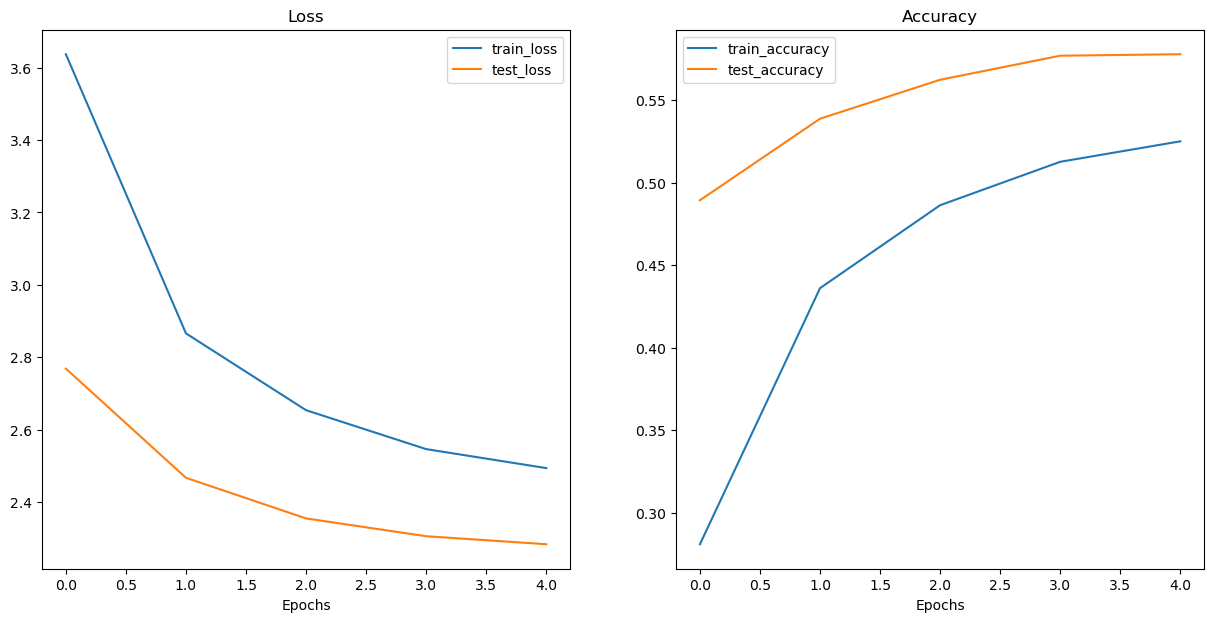

In [201]:
plot_loss_curves(effnetb2_food101_results)

### 10.6 Saving and loading FoodVision Big

In [204]:
from going_modular import utils

# Create a model path
effnetb2_food101_model_path = "pretrained_effnetb2_feature_extractor_food101_20_percent.pth" 

# Save FoodVision Big model
utils.save_model(model=effnet_b2_food101,
                 target_dir="models",
                 model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models\pretrained_effnetb2_feature_extractor_food101_20_percent.pth


In [205]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

Pretrained EffNetB2 feature extractor Food101 model size: 30 MB


## 11. Turning our FoodVision Big model into a deployable app

Why deploy a model?

Deploying a model allows you to see how your model goes in the real-world (the ultimate test set)

Let's create an outline for our FoodVision Big App.

```
demos/
  foodvision_big/
    09_pretrained_effnetb2_feature_extractor_food101_20_percent.pth
    app.py
    class_names.txt
    examples/
      example_1.jpg
    model.py
    requirements.txt


In [207]:
from pathlib import Path

# Create FoodVision Big demp Path
foodvision_big_demo_path = Path('demos/foodvision_big/')

# Make FoodVision Bid demo directory
foodvision_big_demo_path.mkdir(parents=True,
                              exist_ok=True)

# Make FoodVision Big demo examples directory
(foodvision_big_demo_path / 'examples').mkdir(parents=True, exist_ok=True)

### 11.1 Downloading an example image and moving it to the examples directory

In [209]:
import requests
import os

# Image URL (replace with your image link)
image_url = "https://imgs.search.brave.com/fwaAXjtXtyjJDLvJCg0qfb497EFzs2tsZ9_tbyUbGgg/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly9jZG4u/cGl4YWJheS5jb20v/cGhvdG8vMjAyMC8w/OC8xNy8xNC8xNi9w/aXp6YS01NDk1NTQ0/XzY0MC5qcGc"

# Destination directory
save_dir = "demos/foodvision_big/examples/"  # change this to your path

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Image filename (extracted from URL or you can rename it)
filename = os.path.join(save_dir, "downloaded_image.jpg")

# Download the image
response = requests.get(image_url)

# Save the image to the specified directory
with open(filename, 'wb') as file:
    file.write(response.content)

print(f"Image saved to {filename}")


Image saved to demos/foodvision_big/examples/downloaded_image.jpg


In [210]:
# Move trained model to FoodVision Bid demo folder
import shutil

src = "models/pretrained_effnetb2_feature_extractor_food101_20_percent.pth"
dst = "demos/foodvision_big/pretrained_effnetb2_feature_extractor_food101_20_percent.pth"

shutil.move(src, dst)

print("File moved successfully!")


File moved successfully!


### 11.2 Saving Food101 class names to file (class_names.txt)

In [212]:
# Check out the first 10 Food101 class names
food_101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [214]:
# Create path to Food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"

# Write Food101 class names list to file
with open(foodvision_big_class_names_path, "w") as f:
    print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
    f.write("\n".join(food_101_class_names)) # leave a new line between each class

[INFO] Saving Food101 class names to demos\foodvision_big\class_names.txt


In [215]:
# Open Food101 class names file and read each line into a list
with open(foodvision_big_class_names_path, "r") as f:
    food101_class_names_loaded = [food.strip() for food in  f.readlines()]
    
# View the first 5 class names loaded back in
food101_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

### 11.3 Turning our FoodVision Big model into a Python script (model.py)

In [216]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )
    
    return model, transforms

Writing demos/foodvision_big/model.py


### 11.4 Turning our FoodVision Big Gradio app into a Python script (app.py)

In [218]:
%%writefile demos/foodvision_big/app.py

import gradio as gr
import os 
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open('class_names.txt', 'r') as f:
    class_names = [food_name.strip() for food_name in f.readlines()]

### 2. Model and transform preparation 
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=101, # could also use len(class_names)
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="pretrained_effnetb2_feature_extractor_food101_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Big 🍔👁"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food into [101 different classes](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/food101_class_names.txt)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface 
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description
)

# Launch the app!
demo.launch()


Writing demos/foodvision_big/app.py


### 11.5 Creating a requirements file for foodVision Big (requirements.txt)

In [219]:
%%writefile demos/foodvision_big/requirements.txt
torch==2.5.1
torchvision==0.20.1
gradio==5.38.2

Writing demos/foodvision_big/requirements.txt


### 11.6 Deploying our FoodVision Big app to HuggingFace Spaces